IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL.

In [1]:
import os
import sys
import cv2
import numpy as np
from matplotlib.pyplot import figure, imshow, plot, subplot
import pytorchvideo
import pytorch_lightning
import pytorchvideo.models.resnet
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor, save
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from pytorch_lightning.callbacks import RichProgressBar
import pywt

modules_path = 'C:/Users/PMLS/FYP/Modules/'
dataset_path = 'C:/Users/PMLS/FYP/Dataset/STMM'
save_path = "C:/Users/PMLS/FYP/Models"

sys.path.insert(1, modules_path)
from video_dataset import VideoFrameDataset, ImglistToTensor

if False and torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [3]:
# Load dataset
img_w = 640//4
img_h = 480//4
frames_per_video = 7
batch_size = 1

dataset = VideoFrameDataset(
    root_path= f"{dataset_path}",
    annotationfile_path=f"{dataset_path}/annotations.txt",
    num_segments=8,
    frames_per_segment=1,
    imagefile_template='{:01d}.jpg',
    transform=ImglistToTensor(),
    test_mode=False
)
class_map = {0:"down", 1:"left", 2:"right", 3:"up"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.2,0.2,0.6])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

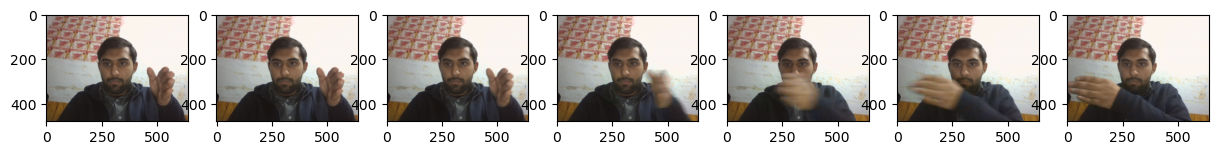

In [7]:
def videoplot(x, t=False):
    figure(1,figsize=(15,5))
    for i in range(7):
        subplot(1,7,i+1)
        imshow(x[i].transpose(0,2).transpose(0,1))
    
for t, (x, y) in enumerate(test_loader):
    videoplot(x[0])
    print("Label:", class_map[y])
    break

In [9]:
# Define model
def make_kinetics_resnet():
    return pytorchvideo.models.resnet.create_resnet(
      input_channel=3,
      model_depth=50,
      model_num_class=4,
      stem_dim_out=batch_size,
      stem_conv_kernel_size=(1, img_w//8, img_h//8),
      stem_conv_stride=(1,2,2),
      norm=torch.nn.BatchNorm3d,
      activation=torch.nn.ReLU,
    )

class VideoClassificationLightningModule(pytorch_lightning.LightningModule):
    def __init__(self):
      super().__init__()
      self.model = make_kinetics_resnet()

    def forward(self, x):
      return self.model(x)
    
    def wavelet_transform(self,batch):
        batch2=[]
        for frame in batch:
            A, B = pywt.dwt(frame, 'db1')
            batch2.append(B)
        return np.array(batch2)

    def grey_transform(self,batch):
        batch = batch.transpose(0,1,3,4,2)
        favg = np.average(batch[0], axis=0)
        grey_avg = cv2.cvtColor(favg, cv2.COLOR_BGR2GRAY)
        batch2 = []
        for frame in batch[0]:
            frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame2 = frame2 - grey_avg
            threshhold = np.max(frame2) * 0.05
            _, frame2 = cv2.threshold(frame2, threshhold, 255, cv2.THRESH_BINARY)
            batch2.append(frame2)
        return np.array([batch2])
    
    def local_transform(self, batch):
        batch = np.array(batch.cpu())
        #batch = self.grey_transform(batch)
        batch = self.wavelet_transform(batch)
        return batch

    def training_step(self, batch, batch_idx):
      x, y = batch
      x = Tensor(self.local_transform(x)).transpose(1,2).to(device)
      y_hat = self.model(x)
      loss = F.cross_entropy(y_hat, y)
      self.log("train_loss", loss.item())
      return loss

    def validation_step(self, batch, batch_idx):
      x, y = batch
      x = Tensor(self.local_transform(x)).transpose(1,2).to(device)
      y_hat = self.model(x)
      loss = F.cross_entropy(y_hat, y)
      self.log("val_loss", loss.item(), prog_bar=True)
      return loss

    def configure_optimizers(self):
      return Adam(self.parameters(), lr=1e-1)

In [11]:
%%time

# Train
model = VideoClassificationLightningModule()
model.train()
model = model.to(device)

trainer = pytorch_lightning.Trainer(max_epochs = 3, max_steps=2500, callbacks=[RichProgressBar()])
trainer.fit(model, train_loader, valid_loader)
print("Training complete")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Net  │  9.6 K │ train │
└───┴───────┴──────┴────────┴───────┘

Trainable params: 9.6 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.6 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 204                                                                                         
Modules in eval mode: 0

Output()

C:\Users\PMLS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

C:\Users\PMLS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=3` reached.


Training complete
CPU times: total: 30min 51s
Wall time: 36min 11s


In [15]:
# Save trained model
torch.save(model,save_path+"/model3.4_wavelet.model")

PicklingError: Can't pickle <function <lambda> at 0x0000020157B59800>: attribute lookup <lambda> on pytorchvideo.models.resnet failed

In [13]:
# Load saved model
model = torch.load(save_path+"/model3.4_wavelet.model")

model = model.eval()
model = model.to(device)

torch.Size([1, 1, 8, 480, 640])


NameError: name 'model' is not defined

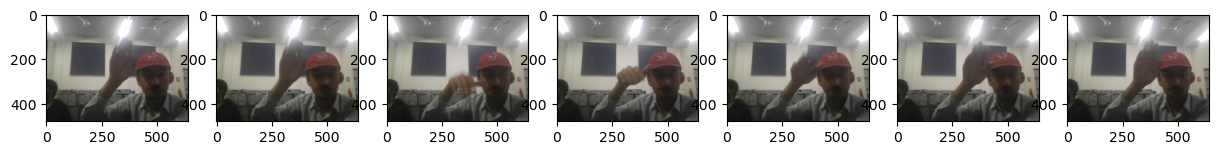

In [5]:
# Manual testing
    
def local_transform(self, batch):
        batch = np.array(batch).transpose(0,1,3,4,2)
        favg = np.average(batch[0], axis=0)
        grey_avg = cv2.cvtColor(favg, cv2.COLOR_BGR2GRAY)
        batch2 = []
        for frame in batch[0]:
            frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame2 = frame2 - grey_avg
            threshhold = np.max(frame2) * 0.05
            _, frame2 = cv2.threshold(frame2, threshhold, 255, cv2.THRESH_BINARY)
            batch2.append([frame2])
        return np.array([batch2])
    
def videoplot(x, t=False):
    if t:
        figure(1,figsize=(15,5))
        for i in range(7):
            subplot(1,7,i+1)
            imshow(x[i].transpose(0,2).transpose(0,1))
    else:
        figure(2,figsize=(15,5))
        for i in range(8):
            subplot(1,8,i+1)
            imshow(x[i], cmap='gray')

for t, (x,y) in enumerate(test_loader):
    videoplot(x[0],True)
    x = local_transform(None, x)
    videoplot(x[0])
    x = Tensor(x).transpose(1,2)
    print(x.shape)
    x = x.to(device)
    scores = model.forward(x)
    _, y_hat = scores.max(1)
    print("Label:", class_map[int(y[0])])
    print("Prediction:", class_map[int(y_hat[0])])
    break

In [21]:
# Validation testing model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            x = VideoClassificationLightningModule.wavelet_transform(None,np.array(x))
            x = Tensor(x).transpose(1,2)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
        num_samples = batch_size*len(loader)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
check_accuracy(valid_loader, model)

Got 91 / 368 correct (24.73)
